# Emulator: Celerite

This notebook provides a template to build an emulator with [Celerite](https://celerite.readthedocs.io/en/stable/). 


#### Index<a name="index"></a>
1. [Import packages](#imports)
2. [Load data](#loadData)
    1. [Load train data](#loadTrainData)
    2. [Load test data](#loadTestData)
3. [Emulator method](#emulator)
    1. [Scale data](#scaleData)
    2. [Train emulator](#trainEmu)
    3. [Plot results](#plotEmu)

## 1. Import packages<a name="imports"></a>


In [10]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pylab

import scipy.optimize as op

import celerite
from celerite import terms
import george

from sklearn.preprocessing import StandardScaler

## 2. Load data<a name="loadData"></a>

Read the training data from a `.pickle` file:

### 2.1. Load training data<a name="loadTrainData"></a>

In [2]:
path_train = '../data/cosmology_train_1d.pickle'

with open(path_train, 'rb') as input_file:
    data_train = pickle.load(input_file)

In [3]:
input_train = data_train['input_data']
output_train = data_train['output_data']
number_train = input_train.shape[0]
number_param = input_train.shape[1] - 1
print("Number of datapoints:", number_train)
print("Number of input parameters:", number_param) # remove the `object_id` column

Number of datapoints: 1000
Number of input parameters: 1


In [4]:
extra_train = data_train['extra_input']
r_vals = extra_train['r_vals']

In [5]:
xs_train = input_train.drop(columns=['object_id'])
ys_train = output_train.drop(columns=['object_id'])

### 2.2. Load test data<a name="loadTrainData"></a> 

In [163]:
path_test = '../data/cosmology_test_1d.pickle'

with open(path_test, 'rb') as input:
    data_test = pickle.load(input)

In [164]:
input_test = data_test['input_data']
output_test = data_test['output_data']
number_test = input_test.shape[0]
print("Number of datapoints:", number_test)

Number of datapoints: 100


In [165]:
xs_test = input_test.drop(columns=['object_id'])
ys_test = output_test.drop(columns=['object_id'])

## 3. Emulator method<a name="emulator"></a>

Let's first scale our input parameters, to make training easier:

In [166]:
scaler = StandardScaler()
scaler.fit(xs_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [167]:
xs_train.iloc[:] = scaler.transform(xs_train)
xs_test.iloc[:] = scaler.transform(xs_test)

We will use `scikit-learn`'s `MLPRegressor` to build our emulator. We train a separate regressor for each output value. We have to tune the hyperparameters carefully.

In [187]:
def fit_gp_celerite(kernel, x, y, x_new):
    
    x = x.iloc[:,0]
    x_new = x_new.iloc[:,0]
    
    def neg_log_like(params,y,gp): 
        gp.set_parameter_vector(params)
        loglike = gp.log_likelihood(y)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.grad_log_likelihood(y)[1]
    
    
    gp = celerite.GP(kernel, mean=0, fit_mean=False)
    gp.compute(x)
    
    print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))
    
    # Fit for the maximum likelihood parameters
    bounds = gp.get_parameter_bounds()
    results = op.minimize(neg_log_like, gp.get_parameter_vector(), 
                       jac=grad_neg_log_like, args=(y, gp))
    gp.set_parameter_vector(results.x)
    print("Final log-likelihood: {0}".format(-results.fun))

    # Make the maximum likelihood prediction
    gp_mean, gp_cov = gp.predict(y, x_new, return_var=True)
    std = np.sqrt(gp_cov)
    
    return gp_mean, gp_cov

In [206]:
y_mean = np.mean(ys_train, axis=0)
ys_train = ys_train/y_mean
ys_test = ys_test/y_mean

In [207]:

number_outputs = np.shape(ys_test)[1]
print(number_outputs)
ys_test_preds = ys_test.copy()
ys_train_0 = ys_train.iloc[:, 0]
for i in np.arange(number_outputs):
    print(i)
    ys_train_i = ys_train.iloc[:, i]
    
    term1 = terms.RealTerm(-1, 8.5)
    
    term2 = terms.JitterTerm(log_sigma=10)
    
    term3 = terms.RealTerm(log_a=np.log(np.var(ys_train_i)+5), log_c=-np.log(5.0))


    # Try different kernels 
    kernel = term1

    ys_pred, ys_cov = fit_gp_celerite(kernel=kernel, x=xs_train, 
                     y=ys_train_i, x_new=xs_test)
    ys_test_preds.iloc[:, i] = ys_pred

10
0
Initial log-likelihood: -1843.9580332619287
Final log-likelihood: 1062.506145563781
1
Initial log-likelihood: -1874.2623493354124
Final log-likelihood: 5520.590021082566
2
Initial log-likelihood: -1915.0303458736335
Final log-likelihood: 1443.0191528736927
3
Initial log-likelihood: -1946.212526885082
Final log-likelihood: 5218.697196927171
4
Initial log-likelihood: -1845.0389655564418
Final log-likelihood: 1056.9647116092467
5
Initial log-likelihood: -1828.537573686921
Final log-likelihood: 1256.1790681369985
6
Initial log-likelihood: -2170.0325219203196
Final log-likelihood: 958.1179738129968
7
Initial log-likelihood: -239074.89329491614
Final log-likelihood: 1486.2974176042285
8
Initial log-likelihood: -1822.3456795444806
Final log-likelihood: 1459.6192041133145
9
Initial log-likelihood: -1780.8994506678416
Final log-likelihood: 6997.199939556736


Undo all the normalizations.

In [208]:
ys_test = ys_test*y_mean
ys_test_preds = ys_test_preds*y_mean

### 3.3. Plot results<a name="plotEmu"></a>

We compare our predictions to the truth (choosing a subset for visual clarity). 

In [209]:
n_plot = int(0.2*number_test)
idxs = np.random.choice(np.arange(number_test), n_plot)
color_idx = np.linspace(0, 1, n_plot)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])

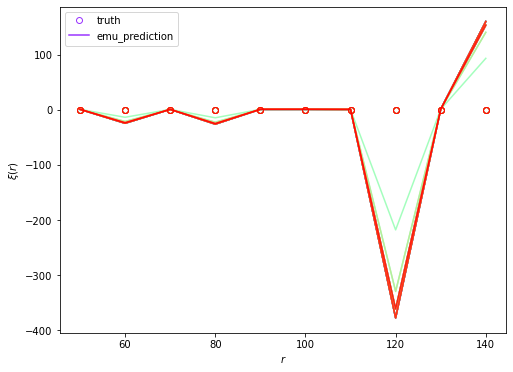

In [210]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_i = ys_test.iloc[idxs[i], :]
    ys_pred_i = ys_test_preds.iloc[idxs[i], :]
    if i==0:
        label_test = 'truth'
        label_pred = 'emu_prediction'
    else:
        label_test = None
        label_pred = None
    plt.plot(r_vals, ys_test_i, alpha=0.8, label=label_test, 
             marker='o', markerfacecolor='None', ls='None', color=colors[i])
    plt.plot(r_vals, ys_pred_i, alpha=0.8, label=label_pred, color=colors[i])
plt.xlabel('$r$')
# plt.ylim(-.001,0.015)
plt.ylabel(r'$\xi(r)$')
plt.legend()


Text(0, 0.5, 'fractional error')

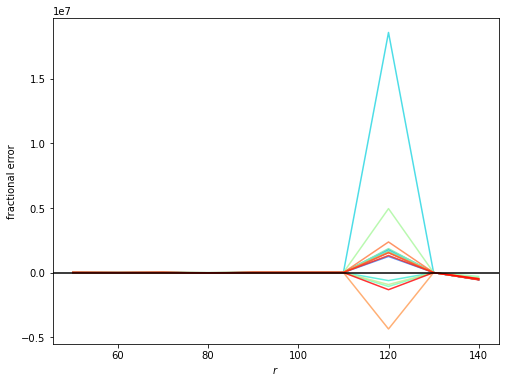

In [211]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_i = ys_test.iloc[idxs[i], :]
    ys_pred_i = ys_test_preds.iloc[idxs[i], :]
    frac_err = (ys_pred_i-ys_test_i)/ys_test_i
    plt.plot(r_vals, frac_err, alpha=0.8, color=colors[i])
plt.axhline(0.0, color='k')
plt.xlabel('$r$')
plt.ylabel(r'fractional error')